# Train and Test 1D Convolutional Neural Network for GNSS

Author: Christopher Liu, 9/26/2021

In [1]:
import os, sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import sift_conv1dnet as sconv
from torch.utils.data import TensorDataset, DataLoader 
import matplotlib.pyplot as plt

## Load Data

In [2]:
# Load dart names
in_fpath = 'sift_ml_input.csv'
if os.path.isfile(in_fpath):
     ml_input = pd.read_csv(in_fpath, dtype = {'unit_sources': str, 'dart': str,\
                                             'lat_d': np.float64, 'long_d': np.float64,\
                                             'extra_forecast': str, 'lat_f': np.float64,\
                                             'long_f': np.float64})
else:
    sys.exit("Error: Unit source file cannot be found.")
dart = ml_input['dart'][ml_input.dart.notnull()].tolist()

# Load fq data
npyd = 'npy'
eta = np.load(os.path.join(npyd,'gnss_eta_z.npy'))

# load unit source TS
dfd = 'unit_src_ts'
eta_us = np.zeros((1440,3,31))
for n, name in enumerate(dart):
    eta_us[:,n,:] = pd.read_csv(os.path.join(dfd,'eta_%s.csv' % name))

# Load inversions (weights and ts)
fq_wts = np.load(os.path.join(npyd,'fq_yong_inv_best.npy'))
fq_ts = np.load(os.path.join(npyd,'fq_wt_eta.npy'))

# Split into train, validation,  and test sets
inddir = 'indices'

train_ind = np.loadtxt(os.path.join(inddir,'fq_dart_train_index.txt')).astype(int)
train_runs= np.loadtxt(os.path.join(inddir,'fq_dart_train_runs.txt')).astype(int)

test_ind = np.loadtxt(os.path.join(inddir,'fq_dart_test_index.txt')).astype(int)
test_runs= np.loadtxt(os.path.join(inddir,'fq_dart_test_runs.txt')).astype(int)

valid_ind = np.loadtxt(os.path.join(inddir,'fq_dart_valid_index.txt')).astype(int)
valid_runs= np.loadtxt(os.path.join(inddir,'fq_dart_valid_runs.txt')).astype(int)

eta_tr = eta[train_runs, :, :]
target_tr = fq_ts[train_ind,:,:360]

eta_ts = eta[test_runs, :, :]
target_ts = fq_ts[test_ind,:,:360]

eta_v = eta[valid_runs, :, :]
target_v = fq_ts[valid_ind,:,:360]

# Convert to tensors. Will need to redo if i want to keep track of run numbers...

batch = 20
shuf = False

train_x = torch.Tensor(eta_tr)
train_y = torch.Tensor(target_tr)

test_x = torch.Tensor(eta_ts)
test_y = torch.Tensor(target_ts)

valid_x = torch.Tensor(eta_v)
valid_y = torch.Tensor(target_v)

us_tn = torch.Tensor(eta_us[:360,:,:])

# Using the pytorch dataloader
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
valid_dataset = TensorDataset(valid_x,valid_y)

train_dataloader = DataLoader(train_dataset, batch_size = batch, shuffle = shuf, drop_last= True)
test_dataloader = DataLoader(test_dataset, batch_size = batch, shuffle = shuf, drop_last= True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch, shuffle = shuf, drop_last= True)

In [3]:
if 0:
    plt.figure(1,figsize=(12,6))
    for r in np.arange(62):
        plt.plot(np.arange(512), eta_ts[100,r,:])

## Train

In [4]:
def valid(dataloader, model, loss_fn):
    size = len(dataloader) # number of batches
    valid_model = model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = valid_model(X)
            
            valid_loss += loss_fn(pred, y).item()
    valid_loss /= size
    
    return valid_loss

In [5]:
# Set Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Set random seed
torch.random.manual_seed(100) #for ae/de, optimizer gets stuck for seed = 100

# Specify model, loss function, and optimizer.
nsources = 31 # Number of unit sources used in inversion
model = sconv.Conv1DNN_GNSS(62, nsources, us_tn).to(device)
#model = sconv.Conv1DNN_GNSS_enc(62, nsources, us_tn).to(device)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using cpu device


In [6]:
epochs = 400
nbatches = len(train_dataloader)
train_loss_array = np.zeros(epochs)
test_loss_array = np.zeros(epochs)
valid_loss_array = np.zeros(epochs)

for t in range(epochs):
    train_loss = 0.0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_func(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # keep track of training loss
        train_loss += loss.item()
    
    # Calculating the batch-averaged loss
    avg_train_loss = train_loss/nbatches
    avg_train_loss_nbn = valid(train_dataloader, model, loss_func)
    avg_valid_loss = valid(valid_dataloader, model, loss_func)
    avg_test_loss = valid(test_dataloader, model, loss_func)
    model.train(True) #Do i need this?
        
    # every 50 epochs, print test error. Adjust print frequency 
    # depending on epoch size
    if (t+1) % 25 == 0:
        print('Epoch: %s' % str(t+1))
        print('------')
        print(f"Avg Train loss: {avg_train_loss:>8f} \n")
        print(f"Avg Train loss w/ eval: {avg_train_loss_nbn:>8f} \n")
        print(f"Avg Validation loss: {avg_valid_loss:>8f} \n")
        print(f"Avg Test loss: {avg_test_loss:>8f} \n")
    
    train_loss_array[t] = avg_train_loss
    valid_loss_array[t] = avg_valid_loss
    test_loss_array[t] = avg_test_loss

Epoch: 25
------
Avg Train loss: 0.009297 

Avg Train loss w/ eval: 0.009298 

Avg Validation loss: 0.009538 

Avg Test loss: 0.008739 

Epoch: 50
------
Avg Train loss: 0.006660 

Avg Train loss w/ eval: 0.006581 

Avg Validation loss: 0.006835 

Avg Test loss: 0.007264 

Epoch: 75
------
Avg Train loss: 0.006016 

Avg Train loss w/ eval: 0.006629 

Avg Validation loss: 0.007043 

Avg Test loss: 0.008148 

Epoch: 100
------
Avg Train loss: 0.004447 

Avg Train loss w/ eval: 0.004562 

Avg Validation loss: 0.006891 

Avg Test loss: 0.007337 

Epoch: 125
------
Avg Train loss: 0.003449 

Avg Train loss w/ eval: 0.003464 

Avg Validation loss: 0.006574 

Avg Test loss: 0.007493 

Epoch: 150
------
Avg Train loss: 0.001859 

Avg Train loss w/ eval: 0.001965 

Avg Validation loss: 0.005702 

Avg Test loss: 0.006555 

Epoch: 175
------
Avg Train loss: 0.001521 

Avg Train loss w/ eval: 0.002089 

Avg Validation loss: 0.006376 

Avg Test loss: 0.006997 

Epoch: 200
------
Avg Train loss: 0.0

## Plot batch-averaged MSE versus epochs

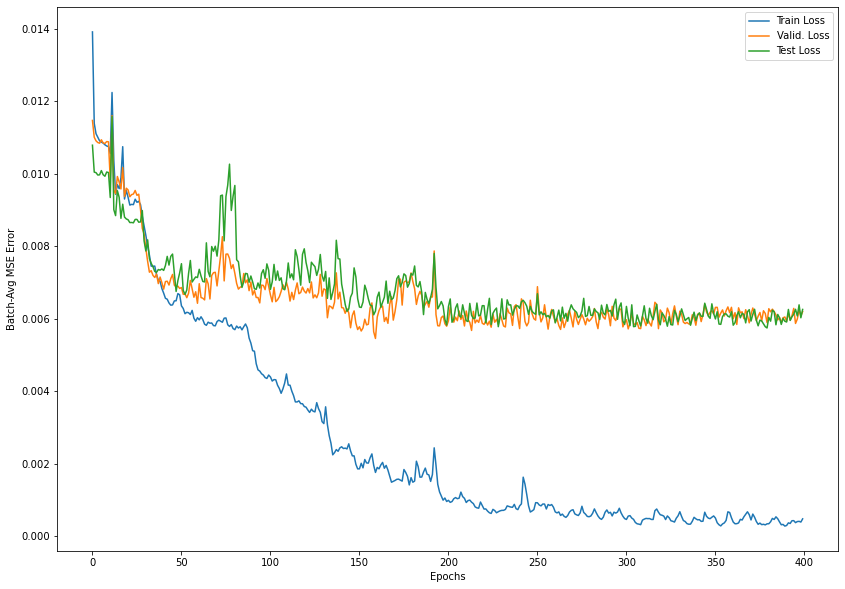

In [7]:
plt.figure(figsize=(14,10))
plt.plot(train_loss_array, label='Train Loss')
plt.plot(valid_loss_array, label='Valid. Loss')
plt.plot(test_loss_array, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Batch-Avg MSE Error')
plt.legend()
#plt.savefig('gnss_fixed_split_s100.png')

## Output results for plotting

Use model to predict test, validiation, and training data.

In [ ]:
# Return intermediate layer output
# See https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

In [ ]:
activations = {}
model.eval() # important to disable dropout/batchnorm layers
with torch.no_grad():
    h1 = model.relu.register_forward_hook(get_activation('test'))
    pred_test = model(test_x)
    h1.remove()
    h2 = model.relu.register_forward_hook(get_activation('train'))
    pred_train = model(train_x)
    h2.remove()
    h3 = model.relu.register_forward_hook(get_activation('valid'))
    pred_valid = model(valid_x)
    h3.remove()
    print(loss_func(pred_test,test_y).item())

In [ ]:
r = 160
plt.figure(figsize = (24,10))
plt.subplot(3,1,1)
plt.plot(pred_test.detach().numpy()[r,0,:], label = 'Predicted')
plt.plot(target_ts[r,0,:], label = 'True')
plt.legend()
plt.subplot(3,1,2)
plt.plot(pred_test.detach().numpy()[r,1,:])
plt.plot(target_ts[r,1,:])
plt.subplot(3,1,3)
plt.plot(pred_test.detach().numpy()[r,2,:])
plt.plot(target_ts[r,2,:])

#### Output results as .npy

In [ ]:
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_test_180.npy'), pred_test.detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_train_180.npy'), pred_train.detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_valid_180.npy'), pred_valid.detach().numpy())

In [ ]:
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_test_ts_250.npy'), activations['test'].detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_train_ts_250.npy'), activations['train'].detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_valid_ts_250.npy'), activations['valid'].detach().numpy())

#### Or alternatively output as a .csv file if you wish to use MATLAB to plot results instead

In [ ]:
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_test_300.csv'),pred_test.detach().numpy(), delimiter=',')
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_train_300.csv'),pred_train.detach().numpy(), delimiter=',')
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_valid_300.csv'),pred_valid.detach().numpy(), delimiter=',')

# Output the model
See https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html for more details such as loading saved models

In [ ]:
# Save the model weights and structure
torch.save(model, 'siftconv1d_model.pth')

# Save ONLY the model weights
torch.save(model.state_dict(), 'siftconv1d_model_wts.pth')

## Load Models

In [ ]:
# Loading the output with weights and structure
model_st = torch.load('siftconv1d_model.pth')
model_st.eval()

# Compare model prediction from above with prediction from the loaded model
# We expect the loss to be 0 if the model was saved and loaded correctly
print(loss_func(model_st(test_x),pred_test).item())

In [ ]:
# Loading the output with ONLY weights
model_wt = sconv.Conv1DNN(3, 31).to(device)
model_wt.load_state_dict(torch.load('siftconv1d_model_wts.pth'))
model_wt.eval()

# Compare model prediction from above with prediction from the loaded model
# We expect the loss to be 0 if the model was saved and loaded correctly
print(loss_func(model_wt(test_x),pred_test).item())